## Previsão Conforme

O presente experimento reutilza o processo de treinamento publicado em [[1]](https://ieeexplore.ieee.org/document/9849852) e disponível no [repositório do GitHub do link](https://github.com/gogoladzetedo/Open_University_Analytics/blob/master/Prediction.ipynb).

O estudo apresenta 3 estudos com 3 diferentes datasets, para a utilização da previsão conforme foi escolhido o terceiro experimento realizado com o dataset [OULAD](https://analyse.kmi.open.ac.uk/open_dataset).



Referências:  

[1] L. Sha, M. Raković, A. Das, D. Gašević and G. Chen, "Leveraging Class Balancing Techniques to Alleviate Algorithmic Bias for Predictive Tasks in Education," in IEEE Transactions on Learning Technologies, vol. 15, no. 4, pp. 481-492, 1 Aug. 2022, doi: 10.1109/TLT.2022.3196278.
keywords: {Predictive models;Task analysis;Prediction algorithms;Analytical models;Data models;Australia;Training;Algorithmic bias;class balancing;machine learning (ML)},



### Importação de bibliotecas, carregamento de dados e agregação dos dados conforme previsto pelo experimento anterior.

In [ ]:
!pip install nonconformist

  Preparing metadata (setup.py) ... done
  Created wheel for nonconformist: filename=nonconformist-2.1.0-py3-none-any.whl size=17818 sha256=c59e9705494b312f32553e8287240bed59251852c7eef5164feb9fc4713ed91b
  Stored in directory: /root/.cache/pip/wheels/50/0c/42/7f1bdc102730e363402b4414413de01d69d9f54c7df9578e32
Successfully built nonconformist


In [ ]:
base_path = 'https://raw.githubusercontent.com/romesdev/oulad/master/data/'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.utils import shuffle


In [ ]:
vle = pd.read_csv(base_path+'vle.csv')
assessments = pd.read_csv(base_path+'assessments.csv')
courses = pd.read_csv(base_path+'courses.csv')
studentAssessment = pd.read_csv(base_path+'studentAssessment.csv')
studentInfo = pd.read_csv(base_path+'studentInfo.csv')
studentRegistration = pd.read_csv(base_path+'studentRegistration.csv')
studentVle = pd.read_csv(base_path+'studentVle.zip', compression='zip')


In [ ]:
# Calculate average clicks of students on VLE activity sites.

clicks = studentVle.groupby(['id_student', 'code_module', 'code_presentation']).agg({'sum_click':'mean'})
clicks.reset_index(level=[0, 1, 2], inplace=True)

results_aged = pd.merge(studentInfo,
                        clicks,
                        how = 'left',
                        left_on = ['id_student', 'code_module', 'code_presentation'],
                        right_on = ['id_student', 'code_module', 'code_presentation'])

In [ ]:
# TO Add average delays in assessment submissions
# result of this cell: the dataset results_aged2 will have column 'delay'
#with average number of days between fixed assessment date and submission date by student.

assessments_totalled = pd.merge(studentAssessment,
                        assessments,
                        how = 'left',
                        left_on = ['id_assessment'],
                        right_on = ['id_assessment'])
assessments_totalled['delay'] = assessments_totalled['date_submitted'] - assessments_totalled['date']
assessments_totalled

student_delays = assessments_totalled.groupby(['code_presentation', 'code_module', 'id_student']).agg({'delay':'mean'})
student_delays.reset_index(level=[0, 1, 2], inplace=True)

results_aged1 = pd.merge(results_aged,
                        student_delays,
                        how = 'left',
                        left_on = ['id_student', 'code_module', 'code_presentation'],
                        right_on = ['id_student', 'code_module', 'code_presentation'])

In [ ]:
results_aged2 = pd.merge(results_aged1,
                        studentRegistration,
                        how = 'left',
                        left_on = ['id_student', 'code_module', 'code_presentation'],
                        right_on = ['id_student', 'code_module', 'code_presentation'])

In [ ]:
set(results_aged2.final_result.values)

{'Distinction', 'Fail', 'Pass', 'Withdrawn'}

Funções auxiliares para calcular as métricas


In [ ]:
# Get class counts
def get_class_counts(y_test):
    class_counts = []
    for i in range(len(class_labels)):
        class_counts.append(np.sum(y_test == i))
    return class_counts

# Get coverage for each class
def get_coverage_by_class(prediction_sets, y_test):
    coverage = []
    for i in range(len(class_labels)):
        coverage.append(np.mean(prediction_sets[y_test == i, i]))
    return coverage

# Get average set size for each class
def get_average_set_size(prediction_sets, y_test):
    average_set_size = []
    for i in range(len(class_labels)):
        average_set_size.append(
            np.mean(np.sum(prediction_sets[y_test == i], axis=1)))
    return average_set_size

# Get weighted coverage (weighted by class size)
def get_weighted_coverage(coverage, class_counts):
    total_counts = np.sum(class_counts)
    weighted_coverage = np.sum((coverage * class_counts) / total_counts)
    weighted_coverage = round(weighted_coverage, 3)
    return weighted_coverage

# Get weighted set_size (weighted by class size)
def get_weighted_set_size(set_size, class_counts):
    total_counts = np.sum(class_counts)
    weighted_set_size = np.sum((set_size * class_counts) / total_counts)
    weighted_set_size = round(weighted_set_size, 3)
    return weighted_set_size

### Cenário 1 do experimento
#### Classificação Multilabel (multiclasse): Pass=1, Distinction=2, Fail = 0, Withdrawn = 3

In [ ]:
# TO define and clean data for the RF model
model_data = results_aged2[[
#'id_student',
'code_module',
'code_presentation',
'gender',
'region',
'highest_education',
'imd_band',
'age_band',
'num_of_prev_attempts',
'studied_credits',
'disability',
'sum_click',
'delay',
'date_registration',
'final_result'
]]

model_data2 = model_data.copy()
model_data2['final_result'] = model_data2['final_result'].map(dict(Pass=2, Distinction=3, Fail = 1, Withdrawn = 0))
model_data2.gender = model_data2.gender.map(dict(M=1, F=0))
model_data2.disability = model_data2.disability.map(dict(Y=1, N=0))

text_columns = [
'code_module',
'code_presentation',
'region',
'highest_education',
'imd_band',
'age_band',
'num_of_prev_attempts',
'studied_credits']

model_data2 = pd.get_dummies(model_data2, columns=text_columns)

In [ ]:
#Clean data from 'na' values
model_data2.sum_click = model_data2.sum_click.fillna(0)
model_data2.date_registration = model_data2.date_registration.fillna(0)
model_data2.delay = model_data2.delay.fillna(0)
model_data2.reset_index(level=[0], inplace=True)

In [ ]:
#Splitting data into main training and testing(validation) datasets, 70/30
model_data_train = model_data2.sample(int(np.floor(model_data2.shape[0] * 0.9)), random_state=999)
model_data_test = model_data2[np.logical_not(model_data2['index'].isin(model_data_train['index']))]

print(model_data_train[model_data_train['final_result'] == 0].shape
    , model_data_train[model_data_train['final_result'] == 3].shape
    , model_data_train[model_data_train['final_result'] == 1].shape
    , model_data_train[model_data_train['final_result'] == 2].shape
     , model_data_test.shape)

(9129, 117) (2713, 117) (6375, 117) (11116, 117) (3260, 117)


In [ ]:
# Undersampling
model_data_train_0 = model_data_train[model_data_train['final_result'] == 0]
model_data_train_1 = model_data_train[model_data_train['final_result'] == 1]
model_data_train_2 = model_data_train[model_data_train['final_result'] == 2]
model_data_train_3 = model_data_train[model_data_train['final_result'] == 3]


model_data_train_new = pd.concat([model_data_train_0, model_data_train_0,
                                  model_data_train_1,
                                  model_data_train_2, model_data_train_2, model_data_train_2, model_data_train_2,
                                  model_data_train_3, ])
print(model_data_train_new.shape)

(71810, 117)


In [ ]:
# model 5: Multilabel

model_data_train_new = model_data_train

In [ ]:
X_train, y_train = shuffle(model_data_train_new[model_data_train_new.columns.difference(['final_result'])],
    model_data_train_new['final_result'], random_state=1)

GridSearch para encontrar os melhores parâmetros

In [ ]:
# # GridSearch to find out the best performing parameters (!!! takes long time, ~50 min)
# param_grid = {
#     'n_estimators': [100, 500, 800, 1100],
#     'max_depth' : [10,20,30,50],
# #    'max_features': ['auto', 'sqrt', 'log2'],
#     'criterion' :['gini', 'entropy']
# }

# CV_rfc = GridSearchCV(estimator=RandomForestClassifier(random_state=1), param_grid=param_grid, cv= 5)
# CV_rfc.fit(X_train, y_train)
# CV_rfc.best_params_
# {'criterion': 'entropy', 'max_depth': 50, 'n_estimators': 1100}


Melhores parâmetros: {'criterion': 'entropy', 'max_depth': 50, 'n_estimators': 1100}

Treinamento do Random Forest com os melhores parâmetros encontrados

In [ ]:
#Train the RF model
rf = RandomForestClassifier(
    n_estimators=1100, max_depth = 50, criterion = 'entropy', random_state = 0).fit(
    X_train, y_train)

Retirada do label do conjunto de teste

In [ ]:
test_dt = model_data_test[model_data_test.columns.difference(['final_result'])]
test_dt_y = model_data_test.final_result
test_dt.shape

(3260, 116)

Separação dos conjuntos de calibração a partir dos dados de teste



In [ ]:
X_test, X_rest2, y_test, y_rest2 = train_test_split(test_dt, test_dt_y, train_size=1000, random_state=42)


In [ ]:
X_calib, X_new, y_calib, y_new = train_test_split(X_rest2, y_rest2, train_size=1000, random_state=67)


Mostrando a probabilidade para cada instância (5 primeiras como exemplo)

In [ ]:
# Get predictions for calibration set
y_pred = rf.predict(X_calib)
y_pred_proba = rf.predict_proba(X_calib)

# Show first 5 instances
y_pred_proba[:5]

array([[0.91090909, 0.07181818, 0.01545455, 0.00181818],
       [0.22818182, 0.42636364, 0.32181818, 0.02363636],
       [0.12181818, 0.26272727, 0.52      , 0.09545455],
       [0.71454545, 0.26      , 0.02363636, 0.00181818],
       [0.31818182, 0.26727273, 0.36818182, 0.04636364]])

Probabilidade final do valor verdadeiro ser predito pelo modelo:

In [ ]:
from sklearn.metrics import classification_report


In [ ]:
print(classification_report(y_calib, y_pred))


              precision    recall  f1-score   support

           0       0.65      0.67      0.66       310
           1       0.46      0.21      0.29       216
           2       0.56      0.87      0.68       371
           3       0.75      0.03      0.06       103

    accuracy                           0.58      1000
   macro avg       0.60      0.44      0.42      1000
weighted avg       0.59      0.58      0.52      1000



In [ ]:
si_scores = []
# Loop through all calibration instances
for i, true_class in enumerate(y_calib):
    # Get predicted probability for observed/true class
    predicted_prob = y_pred_proba[i][true_class-1]
    si_scores.append(1 - predicted_prob)

# Convert to NumPy array
si_scores = np.array(si_scores)

# Show first 5 instances
si_scores[0:5]

array([0.99818182, 0.97636364, 0.73727273, 0.28545455, 0.95363636])



```
# Isto está formatado como código
```

Cálculo do threshold (limiar)

In [ ]:
number_of_samples = len(X_calib)
alpha = 0.05
qlevel = (1 - alpha) * ((number_of_samples + 1) / number_of_samples)
prob_true_class = y_pred_proba[np.arange(len(y_calib)),y_calib]
threshold = np.quantile(1 - prob_true_class, 0.95)
# threshold = np.percentile(si_scores, qlevel*100)
print(f'Threshold: {threshold:0.3f}')

Threshold: 0.893


Plot do limiar

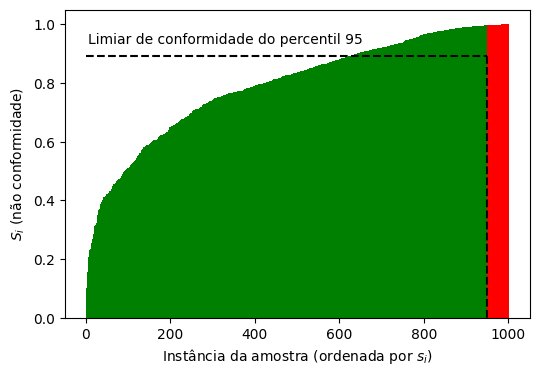

In [ ]:
x = np.arange(len(si_scores)) + 1
sorted_si_scores = np.sort(si_scores)
index_of_95th_percentile = int(len(si_scores) * 0.95)

# Color by cut-off
conform = 'g' * index_of_95th_percentile
nonconform = 'r' * (len(si_scores) - index_of_95th_percentile)
color = list(conform + nonconform)

fig = plt.figure(figsize=((6,4)))
ax = fig.add_subplot()

# Add bars
ax.bar(x, sorted_si_scores, width=1.0, color = color)

# Add lines for 95th percentile
ax.plot([0, index_of_95th_percentile],[threshold, threshold],
        c='k', linestyle='--')
ax.plot([index_of_95th_percentile, index_of_95th_percentile], [threshold, 0],
        c='k', linestyle='--')

txt = 'Limiar de conformidade do percentil 95'
ax.text(5, threshold + 0.04, txt)

# Add axis labels
ax.set_xlabel('Instância da amostra (ordenada por $s_i$)')
ax.set_ylabel('$S_i$ (não conformidade)')


plt.show()


Exemplo de como funciona os conjuntos de predição

In [ ]:
prediction_sets = (1 - rf.predict_proba(X_new) <= threshold)
# Show first ten instances
prediction_sets[0:10]

array([[ True,  True,  True, False],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True, False],
       [ True,  True,  True,  True],
       [ True, False, False, False],
       [ True,  True,  True, False],
       [ True, False, False, False],
       [ True,  True,  True, False],
       [False,  True,  True, False]])

In [ ]:
# montar distribuição do tamanho dos conjuntos

Labels do cenário

In [ ]:
class_labels = [0, 1, 2, 3]

Tabela mostrando o valor verdadeiro da amostra, o conjunto de predição do modelo e a predição final escolhida pelo modelo.

In [ ]:
# Get standard predictions
y_pred = rf.predict(X_new)

# Function to get set labels
def get_prediction_set_labels(prediction_set, class_labels):
    # Get set of class labels for each instance in prediction sets
    prediction_set_labels = [
        set([class_labels[i] for i, x in enumerate(prediction_set) if x]) for prediction_set in
        prediction_sets]
    return prediction_set_labels

# Collate predictions
results_sets = pd.DataFrame()
results_sets['true'] = [class_labels[i-1] for i in y_new]
results_sets['labels'] = get_prediction_set_labels(prediction_sets, class_labels)
results_sets['prediction'] = [class_labels[i] for i in y_pred]
results_sets.head(10)

,true,labels,prediction
0,3,"{0, 1, 2}",0
1,2,"{0, 1, 2, 3}",2
2,1,"{0, 1, 2, 3}",2
3,3,"{0, 1, 2}",0
4,1,"{0, 1, 2, 3}",2
5,3,{0},0
6,1,"{0, 1, 2}",2
7,3,{0},0
8,1,"{0, 1, 2}",2
9,1,"{1, 2}",2


Resumo dos resultados: Quantidade de amostras por classe, a cobertura da classe e o tamanho médio do conjunto de predição para a classe ser incluída.

Cobertura é a proporção de conjuntos de previsão que realmente contêm o resultado verdadeiro.

Tamanho médio do conjunto é o número médio de classes previstas por instância.

In [ ]:
results = pd.DataFrame(index=class_labels)
results['Class counts'] = get_class_counts(y_new)
results['Coverage'] = get_coverage_by_class(prediction_sets, y_new)
results['Average set size'] = get_average_set_size(prediction_sets, y_new)
results

,Class counts,Coverage,Average set size
0,409,0.965770,2.486553
1,249,0.935743,2.839357
2,497,0.993964,2.973843
3,105,0.714286,2.876190


Acurácia do modelo para o cenário.

In [ ]:
weighted_coverage = get_weighted_coverage(
    results['Coverage'], results['Class counts'])

weighted_set_size = get_weighted_set_size(
    results['Average set size'], results['Class counts'])

print (f'Overall coverage: {weighted_coverage}')
print (f'Average set size: {weighted_set_size}')

Overall coverage: 0.95
Average set size: 2.781


In [ ]:
print(classification_report(y_new, rf.predict(X_new)))

              precision    recall  f1-score   support

           0       0.66      0.63      0.64       409
           1       0.40      0.19      0.26       249
           2       0.58      0.86      0.69       497
           3       0.47      0.08      0.13       105

    accuracy                           0.59      1260
   macro avg       0.53      0.44      0.43      1260
weighted avg       0.56      0.59      0.54      1260



### Cenário 2
#### Predição de desistência (0 ou 1)

In [ ]:
# TO define and clean data for the RF model
model_data = results_aged2[[
#'id_student',
'code_module',
'code_presentation',
'gender',
'region',
'highest_education',
'imd_band',
'age_band',
'num_of_prev_attempts',
'studied_credits',
'disability',
'sum_click',
'delay',
'date_registration',
'final_result'
]]

model_data2 = model_data.copy()
#3. model: predicting withdraws
model_data2['final_result'] = model_data2['final_result'].map(dict(Pass=1, Distinction=1, Fail = 1, Withdrawn = 0))
model_data2.gender = model_data2.gender.map(dict(M=1, F=0))
model_data2.disability = model_data2.disability.map(dict(Y=1, N=0))

text_columns = [
'code_module',
'code_presentation',
'region',
'highest_education',
'imd_band',
'age_band',
'num_of_prev_attempts',
'studied_credits']

model_data2 = pd.get_dummies(model_data2, columns=text_columns)

#Clean data from 'na' values
model_data2.sum_click = model_data2.sum_click.fillna(0)
model_data2.date_registration = model_data2.date_registration.fillna(0)
model_data2.delay = model_data2.delay.fillna(0)
model_data2.reset_index(level=[0], inplace=True)

#Splitting data into main training and testing(validation) datasets, 70/30
model_data_train2 = model_data2.sample(int(np.floor(model_data2.shape[0] * 0.9)), random_state=999)
model_data_test2 = model_data2[np.logical_not(model_data2['index'].isin(model_data_train2['index']))]

print(model_data_train2[model_data_train2['final_result'] == 0].shape
    , model_data_train2[model_data_train2['final_result'] == 1].shape
     , model_data_test2.shape)

(9129, 117) (20204, 117) (3260, 117)


Nessa versão, os autores realizaram um balanceamento nos dados utilizando oversampling.

In [ ]:
# model 2: Oversampling
model_data_train_fail = model_data_train2[model_data_train2['final_result'] == 0]
model_data_train_pass = model_data_train2[model_data_train2['final_result'] == 1]
diff = 2*model_data_train_fail.shape[0] - model_data_train_pass.shape[0]

print(model_data_train_fail.shape, model_data_train_pass.shape)

model_data_train_new = pd.concat([model_data_train_pass,
                                  model_data_train_fail,
                                  model_data_train_fail,
                                  model_data_train_fail.sample(abs(diff), random_state = 999)])
print(model_data_train_new.shape)

(9129, 117) (20204, 117)
(40408, 117)


In [ ]:
X_train, y_train = shuffle(model_data_train_new[model_data_train_new.columns.difference(['final_result'])],
    model_data_train_new['final_result'], random_state=1)

Treinamento do segundo modelo com os melhores parâmetros

In [ ]:
rf2 = RandomForestClassifier(
    n_estimators=1100, max_depth = 50, criterion = 'entropy', random_state = 0).fit(
    X_train, y_train)

test_dt2 = model_data_test2[model_data_test2.columns.difference(['final_result'])]
test_dt_y2 = model_data_test2.final_result


In [ ]:
test_dt2.shape

(3260, 116)

Separação do conjunto de calibragem a partir do conjunto de teste

In [ ]:
X_test, X_rest2, y_test, y_rest2 = train_test_split(test_dt2, test_dt_y2, train_size=1000, random_state=42)


In [ ]:
X_calib, X_new, y_calib, y_new = train_test_split(X_rest2, y_rest2, train_size=1000, random_state=67)


Demonstração do conjunto de predições que o modelo gera para cada classe (0 e 1) por amostra.

In [ ]:
# Get predictions for calibration set
y_pred = rf2.predict(X_calib)
y_pred_proba = rf2.predict_proba(X_calib)

# Show first 5 instances
y_pred_proba[0:5]

array([[0.94181818, 0.05818182],
       [0.29818182, 0.70181818],
       [0.12181818, 0.87818182],
       [0.78818182, 0.21181818],
       [0.42181818, 0.57818182]])

Probabilidade do valor verdadeiro conforme a predição do modelo.

In [ ]:
si_scores = []
# Loop through all calibration instances
for i, true_class in enumerate(y_calib):
    # Get predicted probability for observed/true class
    predicted_prob = y_pred_proba[i][true_class-1]
    si_scores.append(1 - predicted_prob)

# Convert to NumPy array
si_scores = np.array(si_scores)

# Show first 5 instances
si_scores[0:5]

array([0.94181818, 0.29818182, 0.87818182, 0.21181818, 0.42181818])

Cálculo do limiar

In [ ]:
number_of_samples = len(X_calib)
alpha = 0.05
qlevel = (1 - alpha) * ((number_of_samples + 1) / number_of_samples)
prob_true_class = y_pred_proba[np.arange(len(y_calib)),y_calib]
threshold = np.quantile(1 - prob_true_class, 0.95)
print(f'Threshold: {threshold:0.3f}')

Threshold: 0.751


Plot do limiar

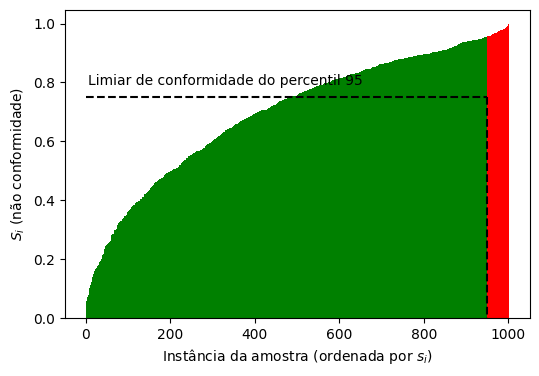

In [ ]:
x = np.arange(len(si_scores)) + 1
sorted_si_scores = np.sort(si_scores)
index_of_95th_percentile = int(len(si_scores) * 0.95)

# Color by cut-off
conform = 'g' * index_of_95th_percentile
nonconform = 'r' * (len(si_scores) - index_of_95th_percentile)
color = list(conform + nonconform)

fig = plt.figure(figsize=((6,4)))
ax = fig.add_subplot()

# Add bars
ax.bar(x, sorted_si_scores, width=1.0, color = color)

# Add lines for 95th percentile
ax.plot([0, index_of_95th_percentile],[threshold, threshold],
        c='k', linestyle='--')
ax.plot([index_of_95th_percentile, index_of_95th_percentile], [threshold, 0],
        c='k', linestyle='--')

txt = 'Limiar de conformidade do percentil 95'
ax.text(5, threshold + 0.04, txt)

# Add axis labels
ax.set_xlabel('Instância da amostra (ordenada por $s_i$)')
ax.set_ylabel('$S_i$ (não conformidade)')


plt.show()


In [ ]:
prediction_sets = (1 - rf2.predict_proba(X_new) <= threshold)
# Show first ten instances
prediction_sets[0:10]

array([[ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [False,  True],
       [ True, False],
       [False,  True],
       [ True, False],
       [ True,  True],
       [False,  True]])

In [ ]:
class_labels = [0, 1]

Tabela com o valor verdadeiro, conjuntos de predição do modelo e escolha final do modelo.

In [ ]:
# Get standard predictions
y_pred = rf2.predict(X_new)

# Function to get set labels
def get_prediction_set_labels(prediction_set, class_labels):
    # Get set of class labels for each instance in prediction sets
    prediction_set_labels = [
        set([class_labels[i] for i, x in enumerate(prediction_set) if x]) for prediction_set in
        prediction_sets]
    return prediction_set_labels

# Collate predictions
results_sets = pd.DataFrame()
results_sets['true'] = [class_labels[i-1] for i in y_new]
results_sets['labels'] = get_prediction_set_labels(prediction_sets, class_labels)
results_sets['prediction'] = [class_labels[i] for i in y_pred]
results_sets.head(10)

,true,labels,prediction
0,1,"{0, 1}",0
1,0,"{0, 1}",1
2,0,"{0, 1}",1
3,1,"{0, 1}",0
4,0,{1},1
5,1,{0},0
6,0,{1},1
7,1,{0},0
8,0,"{0, 1}",1
9,0,{1},1


Resumo dos resultados

In [ ]:
results = pd.DataFrame(index=class_labels)
results['Class counts'] = get_class_counts(y_new)
results['Coverage'] = get_coverage_by_class(prediction_sets, y_new)
results['Average set size'] = get_average_set_size(prediction_sets, y_new)
results

,Class counts,Coverage,Average set size
0,409,0.880196,1.562347
1,851,0.978848,1.378378


In [ ]:
weighted_coverage = get_weighted_coverage(
    results['Coverage'], results['Class counts'])

weighted_set_size = get_weighted_set_size(
    results['Average set size'], results['Class counts'])

print (f'Overall coverage: {weighted_coverage}')
print (f'Average set size: {weighted_set_size}')

Overall coverage: 0.947
Average set size: 1.438


Acurácia do modelo

In [ ]:
accuracy_score(y_new, y_pred)

0.8023809523809524

### Cenário 3
#### Predição de aprovação (0 ou 1)

In [ ]:
# TO define and clean data for the RF model
model_data = results_aged2[[
#'id_student',
'code_module',
'code_presentation',
'gender',
'region',
'highest_education',
'imd_band',
'age_band',
'num_of_prev_attempts',
'studied_credits',
'disability',
'sum_click',
'delay',
'date_registration',
'final_result'
]]

model_data2 = model_data.copy()
#2. model: predicting failures/withdraws
model_data2['final_result'] = model_data2['final_result'].map(dict(Pass=1, Distinction=1, Fail = 0, Withdrawn = 0))
model_data2.gender = model_data2.gender.map(dict(M=1, F=0))
model_data2.disability = model_data2.disability.map(dict(Y=1, N=0))

text_columns = [
'code_module',
'code_presentation',
'region',
'highest_education',
'imd_band',
'age_band',
'num_of_prev_attempts',
'studied_credits']

model_data2 = pd.get_dummies(model_data2, columns=text_columns)

#Clean data from 'na' values
model_data2.sum_click = model_data2.sum_click.fillna(0)
model_data2.date_registration = model_data2.date_registration.fillna(0)
model_data2.delay = model_data2.delay.fillna(0)
model_data2.reset_index(level=[0], inplace=True)

#Splitting data into main training and testing(validation) datasets, 70/30
model_data_train3 = model_data2.sample(int(np.floor(model_data2.shape[0] * 0.9)), random_state=999)
model_data_test3 = model_data2[np.logical_not(model_data2['index'].isin(model_data_train3['index']))]

print(model_data_train3[model_data_train3['final_result'] == 0].shape
    , model_data_train3[model_data_train3['final_result'] == 1].shape
     , model_data_test3.shape)

(15504, 117) (13829, 117) (3260, 117)


O cenário 3 também realiza balanceamento com a técnica oversampling

---



In [ ]:
# model 2: Oversampling
model_data_train_fail = model_data_train3[model_data_train3['final_result'] == 0]
model_data_train_pass = model_data_train3[model_data_train3['final_result'] == 1]
diff = model_data_train_fail.shape[0] - model_data_train_pass.shape[0]

print(model_data_train_fail.shape, model_data_train_pass.shape)

model_data_train_new = pd.concat([model_data_train_pass,
                                  model_data_train_fail,
                                  model_data_train_pass.sample(diff, random_state = 999)])
print(model_data_train_new.shape)

(15504, 117) (13829, 117)
(31008, 117)


In [ ]:
X_train, y_train = shuffle(model_data_train_new[model_data_train_new.columns.difference(['final_result'])],
    model_data_train_new['final_result'], random_state=1)

In [ ]:
#Train the RF model
rf3 = RandomForestClassifier(
    n_estimators=1100, max_depth = 50, criterion = 'entropy', random_state = 0).fit(
    X_train, y_train)


In [ ]:
# Run model on Test Validation data and see the accuracy
test_dt3 = model_data_test3[model_data_test3.columns.difference(['final_result'])]
test_dt_y3 = model_data_test3.final_result
test_dt3

,age_band_0-35,age_band_35-55,age_band_55<=,code_module_AAA,code_module_BBB,code_module_CCC,code_module_DDD,code_module_EEE,code_module_FFF,code_module_GGG,...,studied_credits_630,studied_credits_65,studied_credits_655,studied_credits_70,studied_credits_75,studied_credits_80,studied_credits_85,studied_credits_90,studied_credits_95,sum_click
11,True,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,3.292776
15,True,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,3.166667
16,False,True,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,5.136585
22,False,True,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,3.323529
28,False,True,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,4.815524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32522,False,True,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,3.540000
32544,True,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,1.000000
32564,False,True,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,2.868421
32569,False,True,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,7.192982


In [ ]:
X_test, X_rest2, y_test, y_rest2 = train_test_split(test_dt3, test_dt_y3, train_size=1000, random_state=42)


In [ ]:
X_calib, X_new, y_calib, y_new = train_test_split(X_rest2, y_rest2, train_size=1000, random_state=67)


In [ ]:
# Get predictions for calibration set
y_pred = rf3.predict(X_calib)
y_pred_proba = rf3.predict_proba(X_calib)

# Show first 5 instances
y_pred_proba[0:5]

array([[0.98181818, 0.01818182],
       [0.65181818, 0.34818182],
       [0.36      , 0.64      ],
       [0.97545455, 0.02454545],
       [0.57909091, 0.42090909]])

In [ ]:
si_scores = []
# Loop through all calibration instances
for i, true_class in enumerate(y_calib):
    # Get predicted probability for observed/true class
    predicted_prob = y_pred_proba[i][true_class-1]
    si_scores.append(1 - predicted_prob)

# Convert to NumPy array
si_scores = np.array(si_scores)

# Show first 5 instances
si_scores[0:5]

array([0.98181818, 0.65181818, 0.64      , 0.97545455, 0.57909091])

In [ ]:
number_of_samples = len(X_calib)
alpha = 0.05
qlevel = (1 - alpha) * ((number_of_samples + 1) / number_of_samples)
prob_true_class = y_pred_proba[np.arange(len(y_calib)),y_calib]
threshold = np.quantile(1 - prob_true_class, 0.95)
print(f'Threshold: {threshold:0.3f}')

Threshold: 0.721


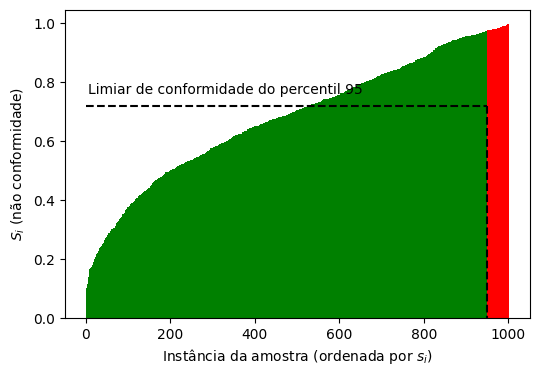

In [ ]:
x = np.arange(len(si_scores)) + 1
sorted_si_scores = np.sort(si_scores)
index_of_95th_percentile = int(len(si_scores) * 0.95)

# Color by cut-off
conform = 'g' * index_of_95th_percentile
nonconform = 'r' * (len(si_scores) - index_of_95th_percentile)
color = list(conform + nonconform)

fig = plt.figure(figsize=((6,4)))
ax = fig.add_subplot()

# Add bars
ax.bar(x, sorted_si_scores, width=1.0, color = color)

# Add lines for 95th percentile
ax.plot([0, index_of_95th_percentile],[threshold, threshold],
        c='k', linestyle='--')
ax.plot([index_of_95th_percentile, index_of_95th_percentile], [threshold, 0],
        c='k', linestyle='--')

# Add text
txt = 'Limiar de conformidade do percentil 95'
ax.text(5, threshold + 0.04, txt)

# Add axis labels
ax.set_xlabel('Instância da amostra (ordenada por $s_i$)')
ax.set_ylabel('$S_i$ (não conformidade)')

plt.show()


In [ ]:
prediction_sets = (1 - rf3.predict_proba(X_new) <= threshold)
# Show first ten instances
prediction_sets[0:10]

array([[ True, False],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [False,  True],
       [ True, False],
       [ True,  True],
       [ True, False],
       [ True,  True],
       [False,  True]])

In [ ]:
class_labels = [0, 1]

In [ ]:
# Get standard predictions
y_pred = rf3.predict(X_new)

# Function to get set labels
def get_prediction_set_labels(prediction_set, class_labels):
    # Get set of class labels for each instance in prediction sets
    prediction_set_labels = [
        set([class_labels[i] for i, x in enumerate(prediction_set) if x]) for prediction_set in
        prediction_sets]
    return prediction_set_labels

# Collate predictions
results_sets = pd.DataFrame()
results_sets['true'] = [class_labels[i-1] for i in y_new]
results_sets['labels'] = get_prediction_set_labels(prediction_sets, class_labels)
results_sets['prediction'] = [class_labels[i] for i in y_pred]
results_sets.head(10)

,true,labels,prediction
0,1,{0},0
1,0,"{0, 1}",1
2,0,"{0, 1}",1
3,1,"{0, 1}",0
4,0,{1},1
5,1,{0},0
6,0,"{0, 1}",1
7,1,{0},0
8,0,"{0, 1}",1
9,0,{1},1


In [ ]:
results = pd.DataFrame(index=class_labels)
results['Class counts'] = get_class_counts(y_new)
results['Coverage'] = get_coverage_by_class(prediction_sets, y_new)
results['Average set size'] = get_average_set_size(prediction_sets, y_new)
results

,Class counts,Coverage,Average set size
0,658,0.936170,1.424012
1,602,0.968439,1.534884


In [ ]:
weighted_coverage = get_weighted_coverage(
    results['Coverage'], results['Class counts'])

weighted_set_size = get_weighted_set_size(
    results['Average set size'], results['Class counts'])

print (f'Overall coverage: {weighted_coverage}')
print (f'Average set size: {weighted_set_size}')

Overall coverage: 0.952
Average set size: 1.477


In [ ]:
accuracy_score(y_new, y_pred)

0.7753968253968254